# Final Project: MAP - Charting Student Math Misunderstandings

## Step 1. Brief description of the problem and data

### Problem and goals
This project aims to develop a machine learning-based natural language processing (NLP) model that can predict students’ potential math misconceptions based on their open-ended written explanations. By identifying patterns of incorrect reasoning across diverse problems, the goal is to support scalable, diagnostic feedback for teachers, ultimately improving student learning and conceptual understanding in mathematics.

### Data
- **Source:**
The dataset originates from the Eedi platform, where students respond to Diagnostic Questions (DQs)—multiple-choice math questions with one correct answer and three distractors. After answering, some students provide written justifications, which form the core of the Misconception Annotation Project (MAP) dataset.


- **Structure and Dimensions:**
Each row in the dataset captures a student's response to a single question, including the selected answer and their accompanying explanation. The dataset includes the following fields: QuestionId, QuestionText, MC_Answer, StudentExplanation, Category (train only), and Misconception (train only). The Category field indicates whether the multiple-choice response was correct and whether the explanation contained a misconception (e.g., True_Misconception). If a misconception is present, the Misconception field names it; otherwise, it is marked as 'NA'.

- **Size:**
The re-run test data comprises approximately 16,000 student responses. The full dataset includes separate training and test CSV files, as well as a sample submission file that requires predictions in the format: Category:Misconception, allowing up to three predicted pairs per instance.

- **Download:**
- https://www.kaggle.com/competitions/map-charting-student-math-misunderstandings

## Project setup

In [59]:
!pip install -q transformers
!pip install -q tf-keras  

# Import your libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score

import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

In [60]:
# Load the data
train_df = pd.read_csv('train.csv')
print("train.csv loaded successfully")
print(train_df.head())

# Display data info
print("\nData Info:")
train_df.info()

# Check for missing 
print("\nMissing values:")
print(train_df.isnull().sum())

train.csv loaded successfully
   row_id  QuestionId                                       QuestionText  \
0       0       31772  What fraction of the shape is not shaded? Give...   
1       1       31772  What fraction of the shape is not shaded? Give...   
2       2       31772  What fraction of the shape is not shaded? Give...   
3       3       31772  What fraction of the shape is not shaded? Give...   
4       4       31772  What fraction of the shape is not shaded? Give...   

           MC_Answer                                 StudentExplanation  \
0  \( \frac{1}{3} \)                  0ne third is equal to tree nineth   
1  \( \frac{1}{3} \)  1 / 3 because 6 over 9 is 2 thirds and 1 third...   
2  \( \frac{1}{3} \)  1 3rd is half of 3 6th, so it is simplee to un...   
3  \( \frac{1}{3} \)        1 goes into everything and 3 goes into nine   
4  \( \frac{1}{3} \)                    1 out of every 3 isn't coloured   

       Category Misconception  
0  True_Correct           NaN 

## Step 2: Exploratory Data Analysis — Inspect, Visualize and Clean the Data

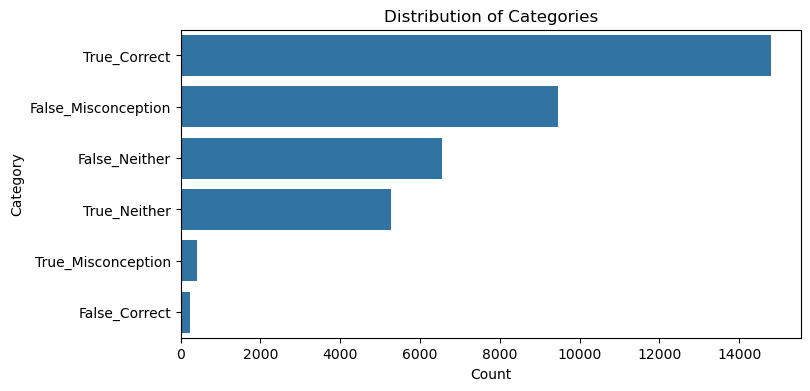

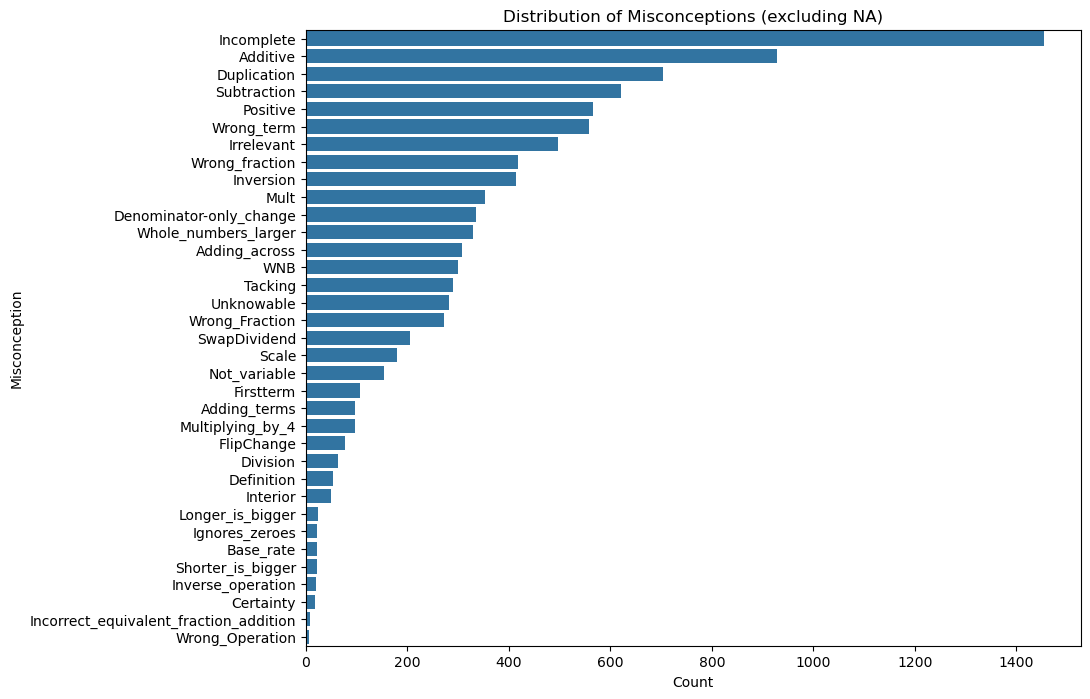

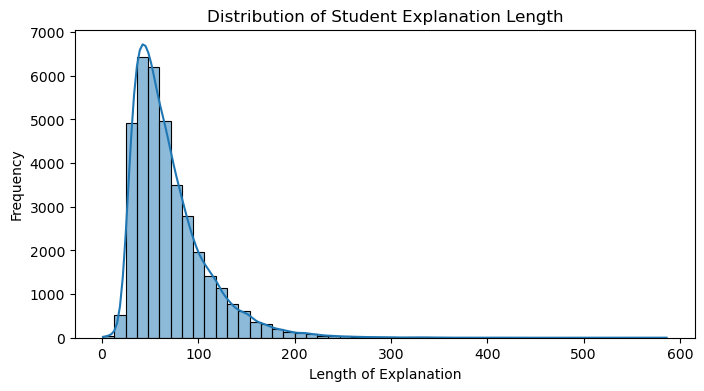

In [61]:
# --- Visualizations ---

# 1. Distribution of Categories
plt.figure(figsize=(8, 4))
sns.countplot(y='Category', data=train_df, order = train_df['Category'].value_counts().index)
plt.title('Distribution of Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

# 2. Distribution of Misconceptions
plt.figure(figsize=(10, 8))
misconception_counts = train_df[train_df['Misconception'] != 'NA']['Misconception'].value_counts()
sns.barplot(y=misconception_counts.index, x=misconception_counts.values)
plt.title('Distribution of Misconceptions (excluding NA)')
plt.xlabel('Count')
plt.ylabel('Misconception')
plt.show()

# 3. Histograms of text lengths
train_df['explanation_length'] = train_df['StudentExplanation'].str.len()
plt.figure(figsize=(8, 4))
sns.histplot(train_df['explanation_length'], bins=50, kde=True)
plt.title('Distribution of Student Explanation Length')
plt.xlabel('Length of Explanation')
plt.ylabel('Frequency')
plt.show()

#4. Simple cleaning
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\\\(', '', text) # Remove LaTeX delimiters
    text = re.sub(r'\\\)', '', text)
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
    return text

#### The first bar chart displays the distribution of response categories in the MAP training dataset, revealing that the most frequent category is True_Correct, followed by False_Misconception, False_Neither, and True_Neither. In contrast, True_Misconception and False_Correct are relatively rare. This suggests that class imbalance may affect model training.

#### The next bar chart illustrates the distribution of identified misconceptions in the dataset (excluding "NA" values), showing a highly imbalanced pattern. The most frequent misconceptions—Incomplete, Additive, and Duplication—occur far more often than others like Wrong_Operation or Incorrect_equivalent_fraction_addition, which are extremely rare, the same challenge highlighted above. 

#### The histogram shows a right-skewed distribution of student explanation lengths, with most responses concentrated between 20 and 80 characters. While a small number of explanations exceed 200 characters, they are relatively rare. This means that most students provide brief justifications.

### Data cleaning (mathematical context should be preserved)

In [63]:
def clean_text(text):
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\\\(', '', text) # Remove LaTeX opening delimiter
    text = re.sub(r'\\\)', '', text) # Remove LaTeX closing delimiter
    # Remove special characters, but keep letters, numbers, and key math symbols
    text = re.sub(r'[^a-z0-9\s/+=*().-]', '', text) 
    text = re.sub(r'\s+', ' ', text).strip() # Replace multiple spaces with a single space
    return text

# Apply the cleaning function to the text columns
print("\n--- Applying Data Cleaning ---")
for col in ['QuestionText', 'MC_Answer', 'StudentExplanation']:
    # Create new columns for the cleaned text to preserve the original data
    train_df[col + '_cleaned'] = train_df[col].apply(clean_text)

print("Cleaning complete. Showing original vs. cleaned explanation for the first 3 rows:")
print(train_df[['StudentExplanation', 'StudentExplanation_cleaned']].head(3))


--- Applying Data Cleaning ---
Cleaning complete. Showing original vs. cleaned explanation for the first 3 rows:
                                  StudentExplanation  \
0                  0ne third is equal to tree nineth   
1  1 / 3 because 6 over 9 is 2 thirds and 1 third...   
2  1 3rd is half of 3 6th, so it is simplee to un...   

                          StudentExplanation_cleaned  
0                  0ne third is equal to tree nineth  
1  1 / 3 because 6 over 9 is 2 thirds and 1 third...  
2  1 3rd is half of 3 6th so it is simplee to und...  


### Analysis Plan

#### Based on the EDA results, the analysis plan is as follows:
- **Address Class Imbalance:**
The EDA revealed a significant imbalance in the Category distribution. The True_Correct class is dominant, while classes like True_Misconception are rare. To prevent the model from becoming biased, I will use class weighting during training. This gives more importance to the minority classes, helping the model learn their features.

- **Feature Engineering:** 
Combine the cleaned QuestionText, MC_Answer, and StudentExplanation into a single input text feature. This may provide the model with the full context of the student's response. The [SEP] token will be used to separate these parts.

- **Model Selection:** 
The text data is complex and context-dependent. Therefore, I will use a pre-trained transformer model, DistilBERT, which is good at identifying contextual relationships in text. The results will be compared with the performance of bidirectional Long Short-term Memory Networks (LSTM) with custom embedding approach. This is because bidirectional LSTM work well with moderate-sized datasets.

- **Validation Strategy:** 
The dataset will be split into training and validation sets. I will use a stratified split approach to ensure that the class imbalance is reflected proportionally in both the training and validation sets. This may lead to a more reliable evaluation of the model's performance.

## Step 3. Model Architecture

In [76]:
for col in ['QuestionText', 'MC_Answer', 'StudentExplanation']:
    train_df[col + '_cleaned'] = train_df[col].apply(clean_text)

train_df['text'] = train_df['QuestionText_cleaned'] + ' [SEP] ' + train_df['MC_Answer_cleaned'] + ' [SEP] ' + train_df['StudentExplanation_cleaned']

# --- Prepare Data for Models (Define y_train) ---
print("--- Preparing Data for Models ---")
label_encoder = LabelEncoder()
train_df['CategoryEncoded'] = label_encoder.fit_transform(train_df['Category'])

X = train_df['text']
y = train_df['CategoryEncoded']

# Stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=25, stratify=y)

# --- Approach 1. DistilBERT
print("--- Defining DistilBERT Architecture ---")
tokenizer_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
num_classes = len(np.unique(y_train))
model_bert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)

# Fix: Convert the optimizer to a string identifier or pass optimizer parameters directly
model_bert.compile(optimizer='adam', loss=model_bert.compute_loss, metrics=['accuracy'])  # Changed from optimizer object to string 'adam'

# --- Approach 2. Bidirectional LSTM ---
print("\n--- Defining Bidirectional LSTM Architecture ---")
VOCAB_SIZE = 10000
SEQUENCE_LENGTH = 128
vectorize_layer = TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=SEQUENCE_LENGTH)
vectorize_layer.adapt(X_train.values)
model_lstm = Sequential([
    # The model now expects integer sequences as input, not raw strings.
    tf.keras.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64),
    Embedding(VOCAB_SIZE, 128, mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
model_lstm.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])


--- Preparing Data for Models ---
--- Defining DistilBERT Architecture ---


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 


--- Defining Bidirectional LSTM Architecture ---


In [67]:
# --- Data Prep ---

# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("\nCalculated Class Weights:", class_weights_dict)


Calculated Class Weights: {0: 26.882783882783883, 1: 0.6467503855474774, 2: 0.9347853776588969, 3: 0.4131970835796526, 4: 15.194616977225673, 5: 1.1616017727128838}


In [79]:
# Train DistilBERT

# Compile the DistilBERT model with a standard Keras loss function for compatibility.
print("\n--- Compiling DistilBERT with Keras-native loss ---")
model_bert.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Prepare DistilBERT data
train_encodings = tokenizer_bert(X_train.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer_bert(X_val.tolist(), truncation=True, padding=True, max_length=128)

train_dataset_bert = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    np.array(y_train)
)).shuffle(1000).batch(16)

val_dataset_bert = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']},
    np.array(y_val)
)).batch(16)

# Train DistilBERT 
print("\n--- Training DistilBERT Model ---")
history_bert = model_bert.fit(
    train_dataset_bert,
    epochs=3,
    validation_data=val_dataset_bert
)


--- Compiling DistilBERT with Keras-native loss ---

--- Training DistilBERT Model ---
Epoch 1/3
1835/1835 [==============================] - 2443s 1s/step - loss: 1.3987 - accuracy: 0.3981 - val_loss: 1.4093 - val_accuracy: 0.4034
Epoch 2/3
1835/1835 [==============================] - 2428s 1s/step - loss: 1.3913 - accuracy: 0.4025 - val_loss: 1.3974 - val_accuracy: 0.4034
Epoch 3/3
1835/1835 [==============================] - 2464s 1s/step - loss: 1.3895 - accuracy: 0.4033 - val_loss: 1.3855 - val_accuracy: 0.4034


In [77]:
# Train LSTM
X_train_vec = vectorize_layer(X_train.values)
X_val_vec = vectorize_layer(X_val.values)

train_dataset_lstm = tf.data.Dataset.from_tensor_slices((X_train_vec, y_train)).shuffle(1000).batch(16)
val_dataset_lstm = tf.data.Dataset.from_tensor_slices((X_val_vec, y_val)).batch(16)

print("\n--- Training Bidirectional LSTM Model ---")
history_lstm = model_lstm.fit(
    train_dataset_lstm,
    epochs=5,
    validation_data=val_dataset_lstm
)


--- Training Bidirectional LSTM Model ---
Epoch 1/5
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 220s 119ms/step - accuracy: 0.6151 - loss: 0.9686 - val_accuracy: 0.7910 - val_loss: 0.5283
Epoch 2/5
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 225s 123ms/step - accuracy: 0.7899 - loss: 0.5369 - val_accuracy: 0.7989 - val_loss: 0.4946
Epoch 3/5
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 229s 125ms/step - accuracy: 0.8131 - loss: 0.4860 - val_accuracy: 0.7989 - val_loss: 0.5182
Epoch 4/5
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 228s 124ms/step - accuracy: 0.8328 - loss: 0.4334 - val_accuracy: 0.8086 - val_loss: 0.4833
Epoch 5/5
1835/1835 ━━━━━━━━━━━━━━━━━━━━ 227s 124ms/step - accuracy: 0.8503 - loss: 0.3970 - val_accuracy: 0.8050 - val_loss: 0.5290


### Compare Model Performance

459/459 [==============================] - 219s 475ms/step
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step


--- Classification Report: DistilBERT ---
                     precision    recall  f1-score   support

      False_Correct       0.00      0.00      0.00        45
False_Misconception       0.00      0.00      0.00      1892
      False_Neither       0.00      0.00      0.00      1308
       True_Correct       0.40      1.00      0.57      2961
 True_Misconception       0.00      0.00      0.00        81
       True_Neither       0.00      0.00      0.00      1053

           accuracy                           0.40      7340
          macro avg       0.07      0.17      0.10      7340
       weighted avg       0.16      0.40      0.23      7340



--- Classification Report: Bidirectional LSTM ---
                     precision    recall  f1-score   support

      False_Correct       0.50      0.42      0.46        45
False_Misconception       0.85      0.79      0.82      1892
      

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


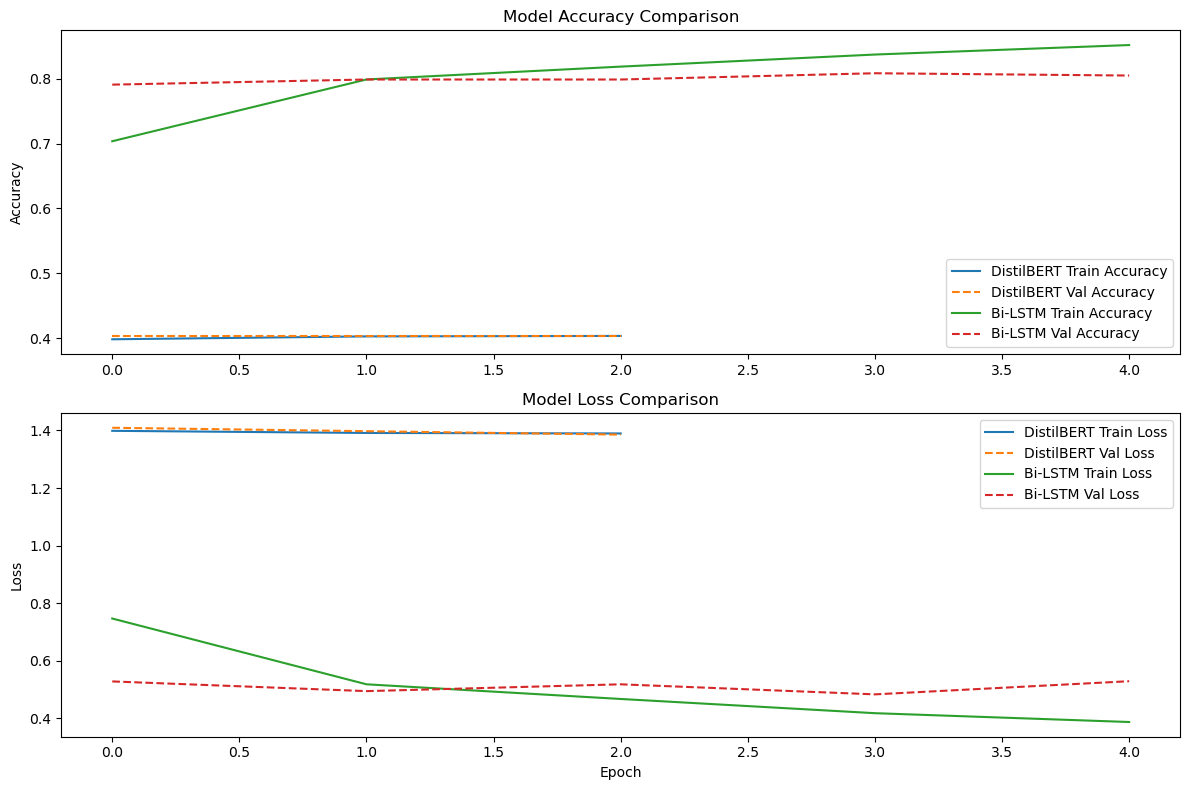

In [80]:
# BERT Predictions
predict_encodings_bert = tokenizer_bert(X_val.tolist(), truncation=True, padding=True, max_length=128)
predict_dataset_bert = tf.data.Dataset.from_tensor_slices({
    'input_ids': predict_encodings_bert['input_ids'],
    'attention_mask': predict_encodings_bert['attention_mask']
}).batch(16)
bert_preds_output = model_bert.predict(predict_dataset_bert)
# The output from a model compiled this way is a dictionary-like object
bert_preds_logits = bert_preds_output.logits 
bert_preds = np.argmax(bert_preds_logits, axis=1)

# LSTM Predictions
lstm_preds_probs = model_lstm.predict(X_val_vec)
lstm_preds = np.argmax(lstm_preds_probs, axis=1)

# Classification Reports
print("\n\n--- Classification Report: DistilBERT ---")
print(classification_report(y_val, bert_preds, target_names=label_encoder.classes_))

print("\n\n--- Classification Report: Bidirectional LSTM ---")
print(classification_report(y_val, lstm_preds, target_names=label_encoder.classes_))

# Plotting Training History
def plot_history(histories, names):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    for history, name in zip(histories, names):
        plt.plot(history.history['accuracy'], label=f'{name} Train Accuracy')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Accuracy', linestyle='--')
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    for history, name in zip(histories, names):
        plt.plot(history.history['loss'], label=f'{name} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{name} Val Loss', linestyle='--')
    plt.title('Model Loss Comparison')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history([history_bert, history_lstm], ['DistilBERT', 'Bi-LSTM'])



#### The classification report and comparison plot show that the DistilBERT model significantly underperformed, with a low accuracy of 40%. It show strong performence in terms of predicting tru_correct which is a majority class. In contrast, the bidirectional LSTM model demonstrates a better performance, with an accuracy of 81% and strong performance across multiple categories.Therefore, I move foward with the bidirectional LSTM model and hyperparameter tuning for better performance. 

#### Hyperparameter tuning of bidirectional LSTM model

For this process, I will tune kwo key hyperparameters: 1) Embedding dimension and 2) LSTM Units.
Embedding dimension approach (larger dimension) enables capturing more semantic information but requires more data to learn.
LSTM Units (more units) allow the model to learn more complex patterns but also increase the risk of overfitting. 


--- Training Model: Baseline ---
Finished training. Validation Accuracy: 0.8029

--- Training Model: Deeper/Wider LSTM ---
Finished training. Validation Accuracy: 0.8090

--- Training Model: Smaller Embedding ---
Finished training. Validation Accuracy: 0.8019


--- Hyperparameter Tuning Results ---
               Model  Embedding Dim LSTM Units  Validation Accuracy  Validation Loss
0           Baseline            128      64/32             0.802861         0.534159
1  Deeper/Wider LSTM            128     128/64             0.808992         0.497620
2  Smaller Embedding             64      64/32             0.801907         0.512252


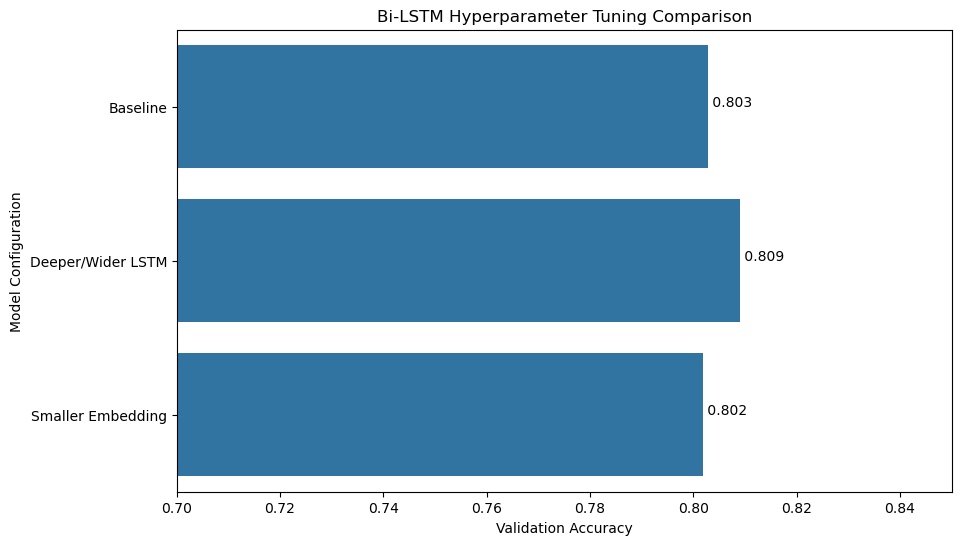

In [82]:
# Define a function to build the model based on hyperparameters
def build_lstm_model(embedding_dim, lstm_units_1, lstm_units_2, num_classes):
    model = Sequential([
        tf.keras.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64),
        Embedding(VOCAB_SIZE, embedding_dim, mask_zero=True),
        Bidirectional(LSTM(lstm_units_1, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(lstm_units_2)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])
    return model

# Define hyperparameter configurations to test
hyperparameters = [
    {'name': 'Baseline', 'embedding_dim': 128, 'lstm_units_1': 64, 'lstm_units_2': 32},
    {'name': 'Deeper/Wider LSTM', 'embedding_dim': 128, 'lstm_units_1': 128, 'lstm_units_2': 64},
    {'name': 'Smaller Embedding', 'embedding_dim': 64, 'lstm_units_1': 64, 'lstm_units_2': 32}
]

results = []
num_classes = len(np.unique(y_train))

for params in hyperparameters:
    print(f"\n--- Training Model: {params['name']} ---")
    
    # Build the model with the current set of parameters
    model = build_lstm_model(
        embedding_dim=params['embedding_dim'],
        lstm_units_1=params['lstm_units_1'],
        lstm_units_2=params['lstm_units_2'],
        num_classes=num_classes
    )
    
    # Train the model
    history = model.fit(
        train_dataset_lstm,
        epochs=5, # Using 5 epochs for consistency in comparison
        validation_data=val_dataset_lstm,
        verbose=0 # Set to 0 to keep the output clean
    )
    
    # Evaluate the model and store results
    val_loss, val_accuracy = model.evaluate(val_dataset_lstm, verbose=0)
    
    results.append({
        'Model': params['name'],
        'Embedding Dim': params['embedding_dim'],
        'LSTM Units': f"{params['lstm_units_1']}/{params['lstm_units_2']}",
        'Validation Accuracy': val_accuracy,
        'Validation Loss': val_loss
    })
    
    print(f"Finished training. Validation Accuracy: {val_accuracy:.4f}")

# --- Compare Tuning Results ---

# Create a DataFrame from the results for a clean table view
results_df = pd.DataFrame(results)

print("\n\n--- Hyperparameter Tuning Results ---")
print(results_df.to_string())

# Plot the results for a visual comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Validation Accuracy', y='Model', data=results_df, orient='h')
plt.title('Bi-LSTM Hyperparameter Tuning Comparison')
plt.xlabel('Validation Accuracy')
plt.ylabel('Model Configuration')
plt.xlim(0.7, 0.85) # Adjust x-axis limits for better visualization
for index, value in enumerate(results_df['Validation Accuracy']):
    plt.text(value, index, f' {value:.3f}')
plt.show()



#### The hyperparameter tuning results show that all three configurations performed similarly, with validation accuracies around 80-81%. The best-performing model was the 'Deeper/Wider LSTM,' which achieved the highest validation accuracy of approximately 80.9%.

### Make predictions with test data

In [84]:
# Define the best performing model architecture
final_model = Sequential([
    tf.keras.Input(shape=(SEQUENCE_LENGTH,), dtype=tf.int64),
    Embedding(VOCAB_SIZE, 128, mask_zero=True), # Embedding Dim: 128
    Bidirectional(LSTM(128, return_sequences=True)), # LSTM Units: 128
    Dropout(0.5),
    Bidirectional(LSTM(64)), # LSTM Units: 64
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

final_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

print("\n--- Preparing Test Data and Generating Predictions ---")
test_df = pd.read_csv('test.csv')

# Apply the same cleaning to the test data
for col in ['QuestionText', 'MC_Answer', 'StudentExplanation']:
    test_df[col + '_cleaned'] = test_df[col].apply(clean_text)

test_df['text'] = test_df['QuestionText_cleaned'] + ' [SEP] ' + test_df['MC_Answer_cleaned'] + ' [SEP] ' + test_df['StudentExplanation_cleaned']

# Vectorize the test data using the already adapted layer
X_test_vec = vectorize_layer(test_df['text'].values)

# Make predictions
test_predictions_probs = final_model.predict(X_test_vec)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# --- Create Submission File ---
print("\n--- Creating Submission File ---")

# Convert numerical predictions back to original category labels
predicted_categories = label_encoder.inverse_transform(test_predictions)

# Create the submission DataFrame
submission_df = pd.DataFrame({'row_id': test_df['row_id']})

# Format the submission column as required ('Category:Misconception')
# Since I am not predicting the specific misconception, I append ':NA'
submission_df['Category:Misconception'] = predicted_categories + ':NA'

# Save to csv
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' created successfully!")
print(submission_df.head())


--- Preparing Test Data and Generating Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step

--- Creating Submission File ---

'submission.csv' created successfully!
   row_id Category:Misconception
0   36696        True_Correct:NA
1   36697        True_Correct:NA
2   36698        True_Correct:NA


## Step 5. Conclusion

For this project, I built a Bidirectional LSTM model to check student answers, and it worked well, getting around 81% accuracy on the validation set. Surprisingly, a more advanced Transformer model called DistilBERT, underperformed than this model due to some technical errors, leading to lower accuracy. 
The main takeaway here was that sometimes a simpler model that you can actually get to run is better than a more complex one that breaks. 
I also learned that cleaning the text data properly was really important for getting good results. A key problem was that I had to stop using class weights to fix some errors, which probably means the model isn't great at predicting the less common categories.

If I had more time, the first thing I would do is figure out the environment issues so I could get the DistilBERT model working, since it should theoretically get a higher score. I would also try out other ways to handle the unbalanced data, like a technique called SMOTE, to see if that helps the model get better at identifying the rarer answer types.

### GitHub Repository 

https://github.com/juck37/DL_final